In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
from tqdm import tqdm, trange

import sys
sys.path.append('../docker/damaris-scripts/')
from machine_learning_across import *

data_basepath = '/home/kjetil/projects/across/machinelearning/across_review/ert_example/'

/home/kjetil/projects/phnn_gitlab/.venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model = NeuralNetwork()

In [3]:
def generate_sample(nx, ny, nz):
    parameter = np.random.uniform(0.0, 1.0)
    x, y, z = np.mgrid[0:1:nx*1j, 0:1:ny*1j, 0:1:nz*1j]
    
    return (x + y + parameter * z).astype(np.float32).reshape(1, nx, ny, nz)

def generate_data(ns, nx, ny, nz):
    all_samples = []
    for _ in range(ns):
        all_samples.append(generate_sample(nx, ny, nz))
    
    return torch.tensor(all_samples)

def get_data(path):
    data = reorder_data(np.loadtxt(path))
    shape = data.shape
    return data.reshape(1, *shape)

def get_all_data_from_file(basepath):
    all_data_files = glob.glob(os.path.join(basepath, 'data_new_model/larger_data_*.txt'))
    all_data = []
    
    for fname in tqdm(all_data_files):
        try:
            new_data = get_data(fname).astype(np.float32)
            all_data.append(new_data)
        except IndexError:
            pass
    print(f"{len(all_data)=}")
    return torch.tensor(all_data)

In [4]:
data = get_all_data_from_file(data_basepath)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 972/972 [00:09<00:00, 107.70it/s]
/tmp/ipykernel_1328305/3558260843.py:30: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  return torch.tensor(all_data)


len(all_data)=972


In [5]:
print(data.shape)
print(f"{model.dnn_down(data).shape=}")
print(f"{model.forward(data).shape=}")
print(f"{data.shape=}")
print(f"{nn.MSELoss()(model.forward(data), data)=}")

torch.Size([972, 1, 24, 20, 20])
model.dnn_down(data).shape=torch.Size([972, 1, 6, 5, 5])
model.forward(data).shape=torch.Size([972, 1, 24, 20, 20])
data.shape=torch.Size([972, 1, 24, 20, 20])
nn.MSELoss()(model.forward(data), data)=tensor(122670.1562, grad_fn=<MseLossBackward0>)


In [6]:
data.shape

torch.Size([972, 1, 24, 20, 20])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [04:35<00:00,  2.75s/it, epoch=100, shape=torch.Size([12, 1, 24, 20, 20]), train_loss=293]


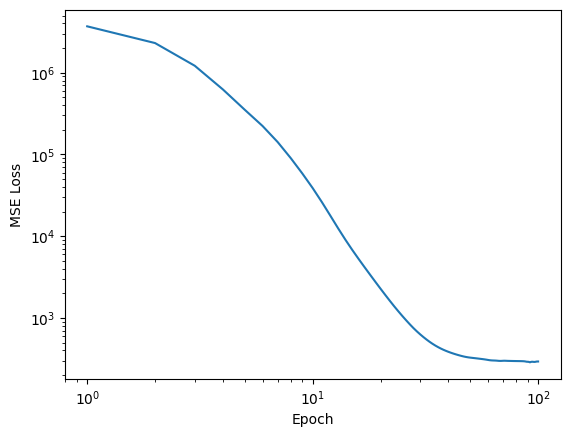

In [7]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
n_epochs = 100
loss_function = nn.MSELoss()
train_loader = torch.utils.data.DataLoader(data, batch_size=32, num_workers=0)
loss_per_epoch = []
with trange(1, n_epochs + 1) as t:
    for epoch in t:
        train_loss = 0.0

        for samples in train_loader:
            optimizer.zero_grad()
            outputs = model(samples)
            loss = loss_function(outputs, samples)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()*samples.size(0)

        train_loss = train_loss/len(train_loader)
        t.set_postfix(epoch=epoch, train_loss=train_loss, shape=samples.shape)
        loss_per_epoch.append(train_loss)
        
plt.loglog(np.arange(1, n_epochs+1), loss_per_epoch)
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.show()

In [8]:
x = torch.tensor(np.zeros((4,5)))

In [9]:
model.dnn_down(data[0, :, :]).shape

torch.Size([1, 6, 5, 5])

In [21]:
import plotly.graph_objects as go
import numpy as np
nx = 20
ny = 20
nz = 24
X, Y, Z = np.mgrid[0:1:nx*1j, 0:1:ny*1j, 0:1:nz*1j]

fig = go.Figure(data=go.Volume(
    x=X.flatten(),
    y=Y.flatten(),
    z=Z.flatten(),
    value=data[100,0,:,:,:].flatten(),
    isomin=350,
    isomax=390,
    opacity=0.1, # needs to be small to see through all surfaces
    surface_count=17, # needs to be a large number for good volume rendering
    ))
fig.show()

In [24]:
fig = go.Figure(data=go.Volume(
    x=X.flatten(),
    y=Y.flatten(),
    z=Z.flatten(),
    value=model.forward(data[100,:,:,:,:]).detach().numpy().flatten(),
    isomin=350,
    isomax=390,
    opacity=0.1, # needs to be small to see through all surfaces
    surface_count=17, # needs to be a large number for good volume rendering
    ))
fig.show()

Text(0, 0.5, 'MSE Loss')

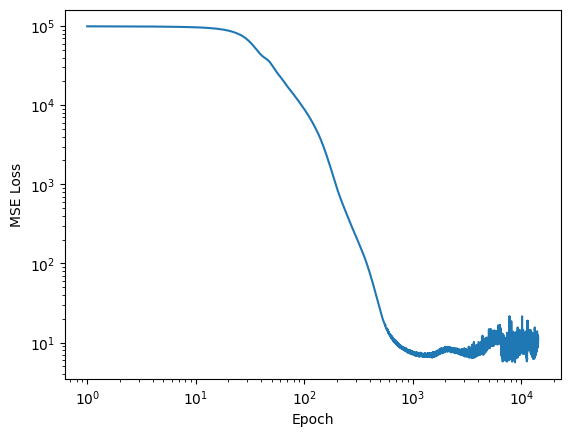

In [41]:
model_insitu = NeuralNetwork()
model_insitu.load_state_dict(torch.load('../ert_example/data_new_model/training_model.torch'))
model_insitu.eval()
loss_insitu = np.loadtxt('../ert_example/data_new_model/training_loss.txt')
plt.loglog(np.arange(1, loss_insitu.shape[0]+1), loss_insitu)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')

In [38]:

fig = go.Figure(data=go.Volume(
    x=X.flatten(),
    y=Y.flatten(),
    z=Z.flatten(),
    value=model_insitu.forward(data[100,:,:,:,:]).detach().numpy().flatten(),
    isomin=350,
    isomax=390,
    opacity=0.1, # needs to be small to see through all surfaces
    surface_count=17, # needs to be a large number for good volume rendering
    ))
fig.show()

In [43]:
model_insitu.dnn_down(data[0,:,:,:,:]).shape

torch.Size([1, 6, 5, 5])